In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 


Dataset Loaded Successfully!
         Date Crime_Category  Crime_Count
0  2021-01-01          Theft           58
1  2021-01-01        Assault           31
2  2021-01-01          Fraud           17
3  2021-01-01        Robbery           17
4  2021-01-01       Burglary           20

Model training completed!

Model Performance:
MAE: 3.9424707923020623
R2 Score: 0.9113596321942998


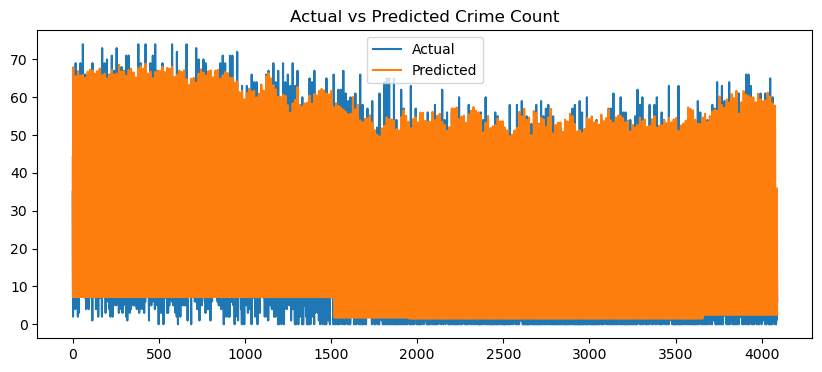


NEXT 60 DAYS PREDICTION:
         Date  Predicted_Crime_Count
0  2025-01-01              29.087435
1  2025-01-02              30.276082
2  2025-01-03              29.854761
3  2025-01-04              21.974012
4  2025-01-05              23.961032
5  2025-01-06              23.884328
6  2025-01-07              25.488274
7  2025-01-08              26.208292
8  2025-01-09              26.341613
9  2025-01-10              26.556730
10 2025-01-11              25.570608
11 2025-01-12              24.238524
12 2025-01-13              24.242058
13 2025-01-14              24.527577
14 2025-01-15              24.792314
15 2025-01-16              25.678293
16 2025-01-17              26.066416
17 2025-01-18              25.769297
18 2025-01-19              26.847566
19 2025-01-20              28.400661
20 2025-01-21              32.604415
21 2025-01-22              32.471346
22 2025-01-23              31.782037
23 2025-01-24              29.309269
24 2025-01-25              27.165191
25 2025-01-2

In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# ---------------------------------------------------
# 1. LOAD DATASET
# ---------------------------------------------------
df = pd.read_csv("C:\\Users\\DELL\\Downloads\\synthetic_crime_dataset_extended.csv")

print("\nDataset Loaded Successfully!")
print(df.head())

# ---------------------------------------------------
# 2. PREPROCESSING
# ---------------------------------------------------
df["Date"] = pd.to_datetime(df["Date"])

# Time features
df["Day"] = df["Date"].dt.day
df["Month"] = df["Date"].dt.month
df["Year"] = df["Date"].dt.year
df["DayOfWeek"] = df["Date"].dt.weekday

# One-hot encode Crime Category
df = pd.get_dummies(df, columns=["Crime_Category"])

# Target variable
y = df["Crime_Count"]

# Feature columns (excluding target + date)
X = df.drop(columns=["Crime_Count", "Date"])

# Save list of category columns for Streamlit
category_columns = [col for col in X.columns if col.startswith("Crime_Category_")]

# ---------------------------------------------------
# 3. TRAIN / TEST SPLIT
# (no shuffle because it's time-series)
# ---------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# ---------------------------------------------------
# 4. TRAIN MODEL
# ---------------------------------------------------
model = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    random_state=42
)

model.fit(X_train, y_train)
print("\nModel training completed!")

# ---------------------------------------------------
# 5. EVALUATION
# ---------------------------------------------------
y_pred = model.predict(X_test)

print("\nModel Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

plt.figure(figsize=(10, 4))
plt.plot(y_test.values, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title("Actual vs Predicted Crime Count")
plt.legend()
plt.show()

# ---------------------------------------------------
# 6. PREDICT NEXT 60 DAYS FOR ANY CATEGORY
# ---------------------------------------------------
last_date = df["Date"].max()

future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

future_df = pd.DataFrame({"Date": future_dates})

# Time features for future
future_df["Day"] = future_df["Date"].dt.day
future_df["Month"] = future_df["Date"].dt.month
future_df["Year"] = future_df["Date"].dt.year
future_df["DayOfWeek"] = future_df["Date"].dt.weekday

# Example Prediction Category (Change in Streamlit)
category_name = "Assault"

# One-hot encoding for future
for col in category_columns:
    future_df[col] = 0

future_df[f"Crime_Category_{category_name}"] = 1

# Prepare final features
X_future = future_df.drop(columns=["Date"])

future_predictions = model.predict(X_future)

future_df["Predicted_Crime_Count"] = future_predictions

print("\nNEXT 60 DAYS PREDICTION:")
print(future_df[["Date", "Predicted_Crime_Count"]])

future_df.to_csv("next_60_days_prediction.csv", index=False)
print("\nSaved 'next_60_days_prediction.csv'")

# ---------------------------------------------------
# 7. SAVE MODEL + METADATA FOR STREAMLIT
# ---------------------------------------------------
joblib.dump({
    "model": model,
    "features": list(X.columns),
    "category_columns": category_columns
}, "crime_rate_model.pkl")

print("\nModel saved as 'crime_rate_model.pkl'")
